# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
# Convert campaign to categorical for ordering
#months =['January','February','March','April','May','June','July','August','September','October','November','December']
#df_offers['campaign'] = pd.Categorical(df_offers['campaign'], categories=months, ordered=True)
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# make a dataframe combining the two tables (inner join)
df = pd.merge(df_offers, df_transactions)
# make a pivot table with offer indicators for each customer
df_table = df.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
df_table.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller values of SS represent better clustering because they correspond to a smaller spread of the points around its mean, as well as smaller overal spread of distances between all pairs in the cluster.
**note:** The triple sum in the equation for SS above should be divided by 2n (n: number of points in k).

In [5]:
# Store contents of the dataframe to a numpy array for sklearn processing
x_cols = df_table.values
print('Array of customer/offer values:', type(x_cols), x_cols.shape)

Array of customer/offer values: <class 'numpy.ndarray'> (100, 32)


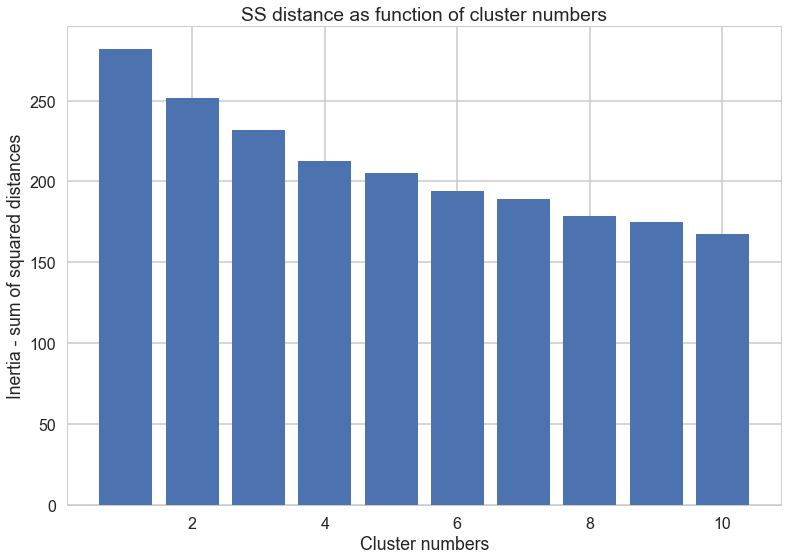

In [6]:
from sklearn.cluster import KMeans
# create an instance of the KMeans model
kmean = KMeans()
# Try different number of clusters K = 2 to 10.
k_values = list(range(1, 11))
ss = []
for k in k_values:
    kmean.n_clusters = k
    kmean.fit(x_cols)
    ss.append(kmean.inertia_)
    
# plot SS as a function of cluster numbers
plt.bar(k_values, ss)
plt.xlabel('Cluster numbers')
plt.ylabel('Inertia - sum of squared distances')
plt.title("SS distance as function of cluster numbers")

No pronounced elbow, but k=3 seems to show a change of trends.

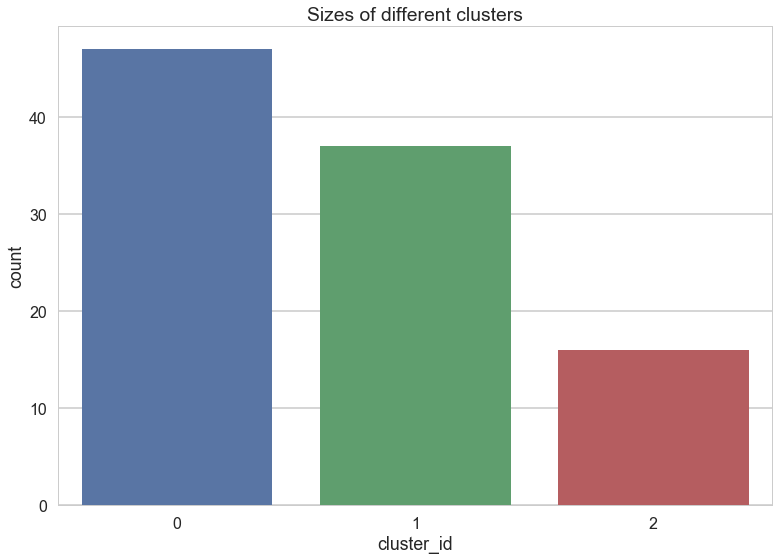

In [7]:
# Choose k=3
kmean.n_clusters = 3
# fit model and get cluster labels
labels = kmean.fit_predict(x_cols)
df_table['cluster_id'] = labels
#print(df_table['cluster_id'].value_counts())
sns.countplot(df_table['cluster_id'])
plt.title('Sizes of different clusters')

The elbow method can be subjective. Moreover, the KMeans algorithm (in this implementation) is not deterministic, so the clusters and SS distances change.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

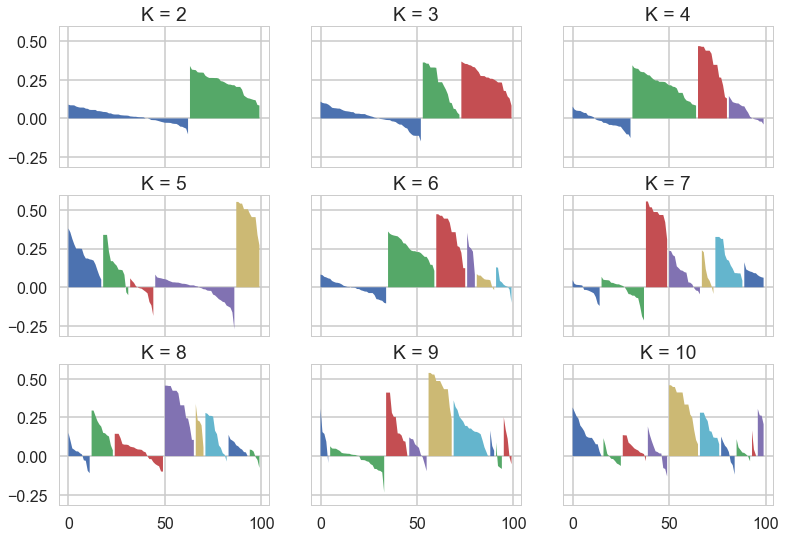

In [8]:
# make silhouette score plots for different values of k
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

kmean = KMeans()
# Try different number of clusters K = 2 to 10.
k_values = list(range(2, 11))

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
scores = []
for k in k_values:
    kmean.n_clusters = k
    cluster_labels = kmean.fit_predict(x_cols)
    
    scores.append(silhouette_score(x_cols, cluster_labels))

    values = silhouette_samples(x_cols, cluster_labels)
    
    axes[(k-2)//3, (k-2)%3].set_title('K = {0}'.format(k))
    
    # individual clusters
    c_shift = 0
    for j in range(k):
        #print('#', k, j, values[cluster_labels == j])
        c_values = values[cluster_labels == j]
        c_values.sort()
        c_size = c_values.shape[0]
        #plt.plot(np.arange(c_size)+c_shift, c_values[::-1])
        axes[(k-2)//3, (k-2)%3].fill_between(np.arange(c_size)+c_shift, c_values[::-1],0)
        c_shift += c_size
        
plt.show() 

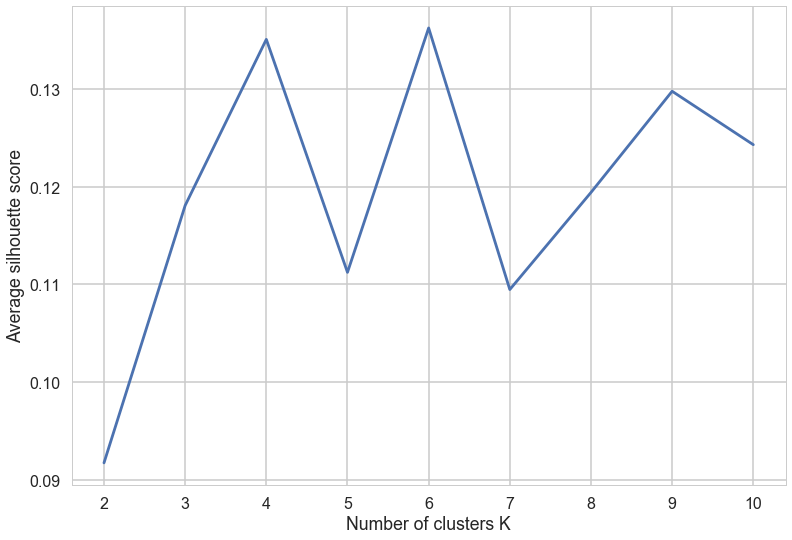

In [9]:
plt.plot(k_values, scores)
plt.xlabel('Number of clusters K')
plt.ylabel('Average silhouette score')

In the present case, the silhouette method does not give a clear guidline how to pick the optimal number of clusters. It could be anywhere between K=3 and 6. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

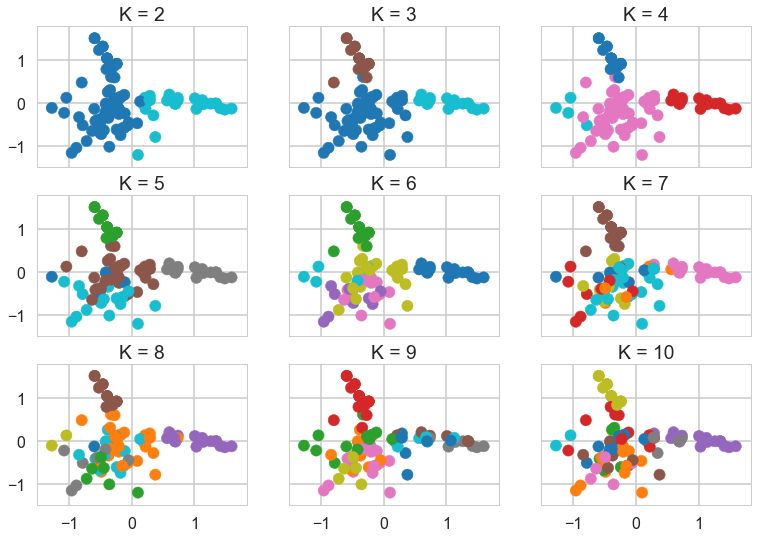

In [10]:
from sklearn.decomposition import PCA

# Perform dimensionality reduction using PCA
pca_model = PCA(n_components=2)
reduced_values = pca_model.fit_transform(x_cols)

# Make a dataframe
df_pca = pd.DataFrame({'customer_name':df_table.index, 'x':reduced_values[:,0], 'y':reduced_values[:,1]})

# Make scatter plots of the 2 principal components colored according to cluster id
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
for k in k_values:
    kmean.n_clusters = k
    # fit model and get cluster labels
    labels = kmean.fit_predict(x_cols)
    df_pca['cluster_id'] = labels
    # make individual plots
    axes[(k-2)//3, (k-2)%3].scatter(df_pca.x, df_pca.y, c=df_pca.cluster_id, cmap='tab10')
    axes[(k-2)//3, (k-2)%3].set_title('K = {0}'.format(k))

Based on the visual inspection of the scatter plots, the previously chosen cluster number K=3 seems optimal. It separates the two 'whiskers' into separate clusters and leaves the points forming the more isotropic structure in its own cluster. In this case, this type of visualization is more clear than the elbow or silhouette methods.

** Find what is common for individual clusters (K=3)

In [11]:
# Fit model for 3 clusters and store results in a new dataframe
kmean = KMeans(n_clusters=3)
labels = kmean.fit_predict(x_cols)
df_clusters = pd.DataFrame({'customer_name':df_table.index, 'cluster_id':labels})

In [12]:
# Make a new dataframe that contains both cluster ID and contents of different offers
df_all = df_transactions.merge(df_clusters, on='customer_name').drop('n', axis=1)
df_all = df_all.merge(df_offers, on='offer_id')
df_all.head()

,customer_name,offer_id,cluster_id,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,2,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,2,January,Pinot Noir,72,17,France,False
2,Martin,2,0,January,Pinot Noir,72,17,France,False
3,Jackson,2,0,January,Pinot Noir,72,17,France,False
4,Campbell,2,2,January,Pinot Noir,72,17,France,False


In [13]:
# create data frames with aggregated values for different offer features
df_campaign = df_all.groupby('cluster_id').campaign.value_counts().to_frame('counts').reset_index()
df_varietal = df_all.groupby('cluster_id').varietal.value_counts().to_frame('counts').reset_index()
df_origin = df_all.groupby('cluster_id').origin.value_counts().to_frame('counts').reset_index()
df_min_qty = df_all.groupby('cluster_id').min_qty.mean().to_frame('mean').reset_index()
df_discount = df_all.groupby('cluster_id').discount.mean().to_frame('mean').reset_index()
df_past_peak = df_all.groupby('cluster_id').past_peak.mean().to_frame('mean').reset_index()

Look at some common features for different clusters (shown only those that seemed interesting)

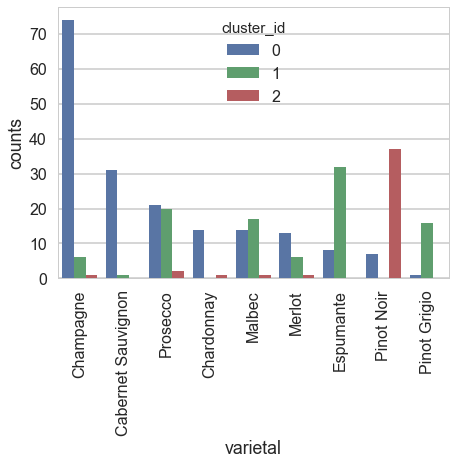

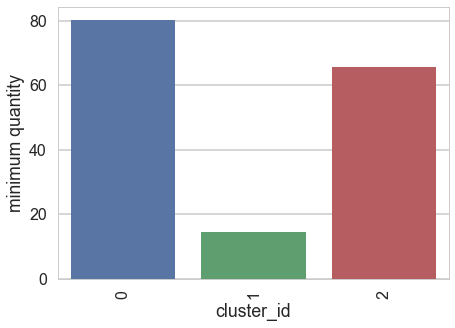

In [14]:
# plot series of count and bar plots comparing offere features for different clusters
figure = plt.figure(figsize=(7,5))
sns.barplot(x='varietal', y='counts', hue='cluster_id', data=df_varietal)
plt.ylabel('counts')
plt.xticks(rotation=90)
plt.show()

figure = plt.figure(figsize=(7,5))
sns.barplot(y='mean', x='cluster_id', data=df_min_qty)
plt.ylabel('minimum quantity')
plt.xticks(rotation=90)
plt.show()

In [15]:
# relation between varietal and minimum quantity
df_corr = df_all[['varietal', 'min_qty']].copy()
df_corr['n'] = 1
df_corr = df_corr.pivot_table(index='min_qty', columns='varietal', values='n', aggfunc='sum', fill_value=0)
df_corr

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
min_qty,,,,,,,,,
6,0,0,0,34,22,6,17,12,19
12,6,9,0,0,0,0,0,7,0
72,16,72,0,0,10,14,0,10,12
144,10,0,15,6,0,0,0,15,12


The 'varietal' and 'minimum quantity' features exhibit the most distinct differences between clusters. Cluster 0 is characterized by large minimum quantities and wines dominated by Champaign and other popular varieties, such as Cabernet. This may correspond to customers ordering for larger celebrations or restaurants. Cluster 2 consists of customers that almost exclusively ordered Pinot Noir, and the purchases were of large quantities. These customers may be buying for restaurants. Cluster 1 is specific in that the average minimum quantity is substantially lower (~6 bottles), which may correspond to individuals that like less common wine varieties, as their choice is nearly complementary to those from the other two clusters. Interestingly, customers in this cluster do not buy Pinot Noir, even if it is available in smaller minimal quantities.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

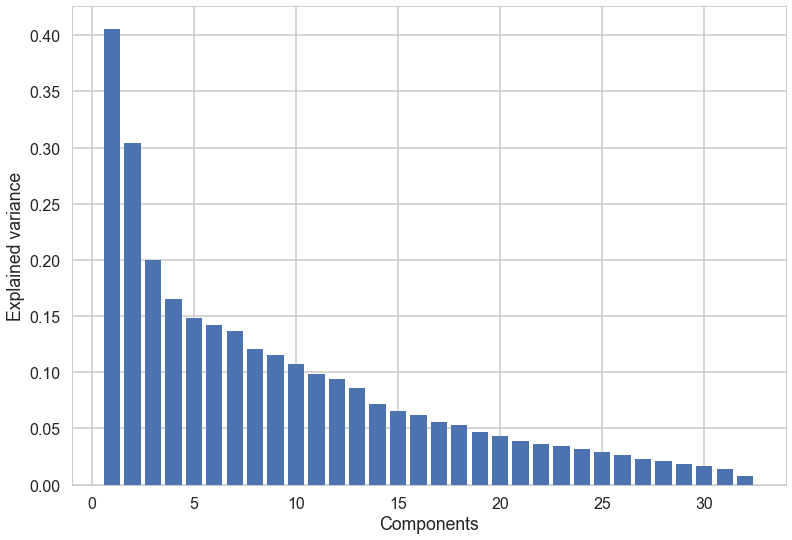

In [16]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# plot explained variance
plt.bar(np.arange(pca.explained_variance_.shape[0])+1, pca.explained_variance_)
plt.xlabel('Components')
plt.ylabel('Explained variance')

The first three components seem to lie before the elbow, and should be thus capture the main features of the data in terms of variance.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


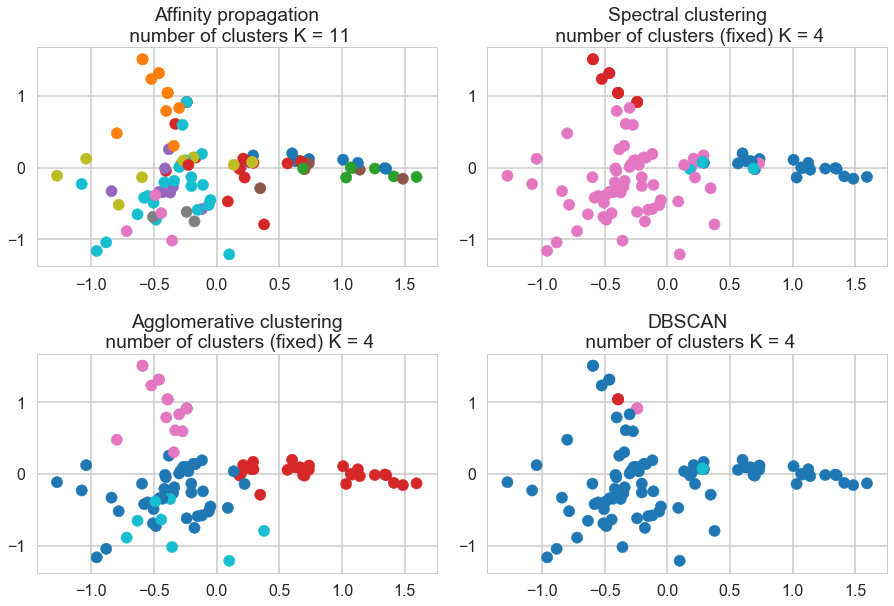

In [17]:
# Compare different clustering algorithms
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

# Perform dimensionality reduction to n=2 using PCA 
pca_model = PCA(n_components=2)
reduced_values = pca_model.fit_transform(x_cols)
pca_x = reduced_values[:,0]
pca_y = reduced_values[:,1]

# Make PCA-based scatter plots for different algorithms
fig, axes = plt.subplots(2, 2)

# Affinity propagation 
afinity = AffinityPropagation(damping=0.972) # use default parameter preference=None, set damping to reduce number of clusters
afinity_labels = afinity.fit_predict(x_cols)
n_afinity = len(set(afinity_labels))

axes[0,0].scatter(pca_x, pca_y, c=afinity_labels, cmap='tab10')
axes[0,0].set_title('Affinity propagation\n number of clusters K = {0}'.format(n_afinity))

# Spectral clustering
spectral = SpectralClustering(n_clusters=4) # use 4 clusters (3 clusters nearly same as KMeans)
spectral_labels = spectral.fit_predict(x_cols)
n_spectral = len(set(spectral_labels))

axes[0,1].scatter(pca_x, pca_y, c=spectral_labels, cmap='tab10')
axes[0,1].set_title('Spectral clustering\n number of clusters (fixed) K = {0}'.format(n_spectral))

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=4) # use 4 clusters (3 clusters nearly same as KMeans)
agglo_labels = agglo.fit_predict(x_cols)
n_agglo = len(set(agglo_labels))

axes[1,0].scatter(pca_x, pca_y, c=agglo_labels, cmap='tab10')
axes[1,0].set_title('Agglomerative clustering\n number of clusters (fixed) K = {0}'.format(n_agglo))

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3) # use default parameter preference=None, set damping to reduce number of clusters
dbscan_labels = dbscan.fit_predict(x_cols)
n_dbscan = len(set(dbscan_labels))

axes[1,1].scatter(pca_x, pca_y, c=dbscan_labels, cmap='tab10')
axes[1,1].set_title('DBSCAN\n number of clusters K = {0}'.format(n_dbscan))

plt.tight_layout()


1. Affinity propagation algorithm produces rather fragmented clusters. The parameter 'dumping' can be changed in the range of 0.5 and 1.0. Values up to ~0.8 produce 14 clusters, values up to 0.972 produce 11 clusters, and larger values produce a single cluster. None of these predictions seem to give useful insights about different groups of customers. 

2. Spectral clustering algorithm with number of clusters K = 3 leads to similar results as the KMeans algorithm. The plot above shows K = 4, to see how the algorithm handles potential overfitting. It turns out that the additional clusters tend to concentrate in the whiskers.

3. Agglomerative clustering algorithm with number of clusters K = 3 leads to similar results as the KMeans and spectral clustering algorithms. The plot above shows K = 4, to see how the algorithm handles potential overfitting. It turns out that the additional clusters tend to concentrate in the area of the main (biggest) cluster, while leaving the whiskers separate. This behavior makes more intuitive sense than the prediction of the spectral clustering algorithm, since there are more features common to the big cluster, which can be potentially separated to smaller groups.

4. The DBSCAN algorithm tends to cluster regions of arbitrary shapes that are connected through regions with high density of data points. In the present case it tends to group all data into a single cluster. Modifying the distance parameter 'eps' and minimum number of samples to be considered core samples, 'min_samples', does not lead to bit changes in the outcome. For parameter combinations that are chosen to identify more than one cluster (as shown in the plot shown above), the results do not make intuitive sense.